In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.models import ColorBar, HoverTool
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, show
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.transform import factor_cmap


In [2]:
# Assuming 'data' is your DataFrame and is already loaded
data = pd.read_csv('Susp_Age_Group.csv', low_memory=False)
data['CMPLNT_NUM'] = data['CMPLNT_NUM'].astype(str)
top_3_offenses = ['HARRASSMENT 2', 'ASSAULT 3 & RELATED OFFENSES', 'PETIT LARCENY'] 
data = data[data['OFNS_DESC'].isin(top_3_offenses)]

In [3]:
# Function to convert lat/long to Web Mercator format
def lat_lon_to_mercator(lat, lon):
    k = 6378137  # Earth radius in meters
    x = lon * (k * np.pi/180.0)
    y = np.log(np.tan((90 + lat) * np.pi/360.0)) * k
    return x, y

# Convert coordinates for the whole dataset
data['x'], data['y'] = zip(*data.apply(lambda row: lat_lon_to_mercator(row['Latitude'], row['Longitude']), axis=1))

# Define bounds for New York State in latitude and longitude
ny_state_north, ny_state_south = 45.011, 40.496
ny_state_east, ny_state_west = -73.496, -79.762

# Convert these bounds to Mercator coordinates
north_y, _ = lat_lon_to_mercator(ny_state_north, 0)
south_y, _ = lat_lon_to_mercator(ny_state_south, 0)
_, east_x = lat_lon_to_mercator(0, ny_state_east)
_, west_x = lat_lon_to_mercator(0, ny_state_west)

# Define New York geographical bounds
ny_north = 45.011
ny_south = 40.496
ny_east = -71.856
ny_west = -79.762

In [4]:
# New York City latitude and longitude
nyc_lat, nyc_lon = 40.7128, -74.0060
# Convert NYC coordinates to Mercator
nyc_x, nyc_y = lat_lon_to_mercator(nyc_lat, nyc_lon)
# Assuming 'data' is your DataFrame and it has 'Latitude' and 'Longitude' columns
data['x'], data['y'] = zip(*data.apply(lambda row: lat_lon_to_mercator(row['Latitude'], row['Longitude']), axis=1))
# Creating a ColumnDataSource
source = ColumnDataSource(data={
    'x': data['x'],
    'y': data['y'],
    'BORO_NM': data['BORO_NM'],
    'SUSP_AGE_GROUP': data['SUSP_AGE_GROUP'],
    'OFNS_DESC': data['OFNS_DESC']
})
# Setting up the figure with focus on New York City
p = figure(x_axis_type="mercator", y_axis_type="mercator", sizing_mode="stretch_width", height=1000,
           x_range=(nyc_x - 20000, nyc_x + 20000), y_range=(nyc_y - 20000, nyc_y + 20000))
p.add_tile(CARTODBPOSITRON)

offense_colors = factor_cmap('OFNS_DESC', palette=['#1F77B4', '#FF7F0E', '#2CA02C'], factors=top_3_offenses)
# Adding points to the map with different colors for each of the top 5 offenses
p.circle(x='x', y='y', source=source, size=8, color=offense_colors, fill_alpha=0.7, legend_field='OFNS_DESC')
# Adding hover tool
hover = HoverTool()
hover.tooltips = [
    ("Borough", "@BORO_NM"),
    ("Suspect Age Group", "@SUSP_AGE_GROUP"),
    ("Offense Description", "@OFNS_DESC")
]
p.add_tools(hover)
# Handling the legend
p.legend.location = "top_left"
p.legend.click_policy="hide"
# Show the map
#output_notebook()
show(p)

Heatmap of Offenses by Borough and Suspect Age Group

In [5]:
# Load the data from the CSV file
data = pd.read_csv("Susp_Age_Group.csv", encoding='utf-8', low_memory=False)

# Replace "(NULLS)" with NaN and then drop NaN values
data['BORO_NM'].replace('(null)', pd.NA, inplace=True)
data.dropna(subset=['BORO_NM'], inplace=True)

In [6]:
# Group by BORO_NM, SUSP_AGE_GROUP, and OFNS_DESC, then count the occurrences
grouped_data = data.groupby(['BORO_NM', 'SUSP_AGE_GROUP', 'OFNS_DESC']).size().reset_index(name='count')
# Sort the data to get the most common offense on top for each combination of borough and age group
sorted_data = grouped_data.sort_values(['BORO_NM', 'SUSP_AGE_GROUP', 'count'], ascending=[True, True, False])
# Drop duplicate combinations of borough and age group, keeping the first occurrence (which is the most common offense)
unique_data = sorted_data.drop_duplicates(subset=['BORO_NM', 'SUSP_AGE_GROUP'])
# Pivot the data for the heatmap
heatmap_data = unique_data.pivot_table(index='SUSP_AGE_GROUP', columns='BORO_NM', values='count', fill_value=0)
# Create a list of boroughs and age groups for the axis of the heatmap
boroughs = list(heatmap_data.columns)
age_groups = list(heatmap_data.index)
# Create a grid for the heatmap
boroughs_grid, age_groups_grid = np.meshgrid(range(len(boroughs)), range(len(age_groups)))
counts = heatmap_data.values.flatten()
# Convert the data to a format suitable for Bokeh
source = ColumnDataSource(data=dict(
    BORO_NM=[boroughs[i] for i in boroughs_grid.flatten()],
    SUSP_AGE_GROUP=[age_groups[j] for j in age_groups_grid.flatten()],
    count=counts,
    OFNS_DESC=[unique_data[unique_data['BORO_NM'] == boroughs[i]].loc[unique_data['SUSP_AGE_GROUP'] == age_groups[j], 'OFNS_DESC'].values[0]
               if heatmap_data.iloc[j, i] > 0 else 'None'
               for i in range(len(boroughs)) for j in range(len(age_groups))]
))
# Using a linear color mapper
mapper = linear_cmap(field_name='count', palette=Viridis256, low=min(counts), high=max(counts))
# Setting up the Bokeh plot
plot = figure(title="Heatmap of Offenses by Borough and Suspect Age Group",
              x_range=boroughs, y_range=list(reversed(age_groups)),
              x_axis_location="above", width=900, height=400,
              tools="hover,pan,box_zoom,reset,wheel_zoom",
              tooltips=[('Borough', '@BORO_NM'), ('Age Group', '@SUSP_AGE_GROUP'), ('Offense', '@OFNS_DESC'), ('Count', '@count')])
# Create Rectangles for the heatmap
plot.rect(x="BORO_NM", y="SUSP_AGE_GROUP", width=1, height=1, source=source,
          fill_color=mapper, line_color=None)
# Add color bar
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0,0))
plot.add_layout(color_bar, 'right')
# Show the plot
output_notebook()  # Display in notebook
show(plot)  # Open a new browser window or tab with the plot

Loading BokehJS ...

Bar Graph of Top 5 Felony Crimes in 2023

In [7]:
top_5_felony = data[data['LAW_CAT_CD'] == 'FELONY']['OFNS_DESC'].value_counts().head(5)
top_5_misdemeanor = data[data['LAW_CAT_CD'] == 'MISDEMEANOR']['OFNS_DESC'].value_counts().head(5)

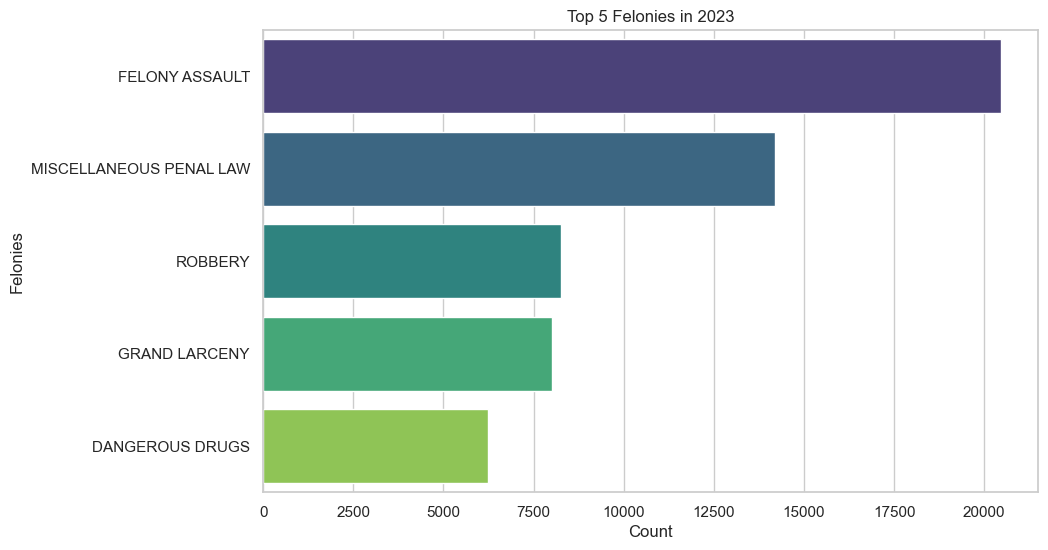

In [8]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_felony.values, y=top_5_felony.index, palette="viridis")
plt.xlabel("Count")
plt.ylabel("Felonies")
plt.title("Top 5 Felonies in 2023")
plt.show()

Bar Graph of Top 5 Misdemeanors Crimes in 2023

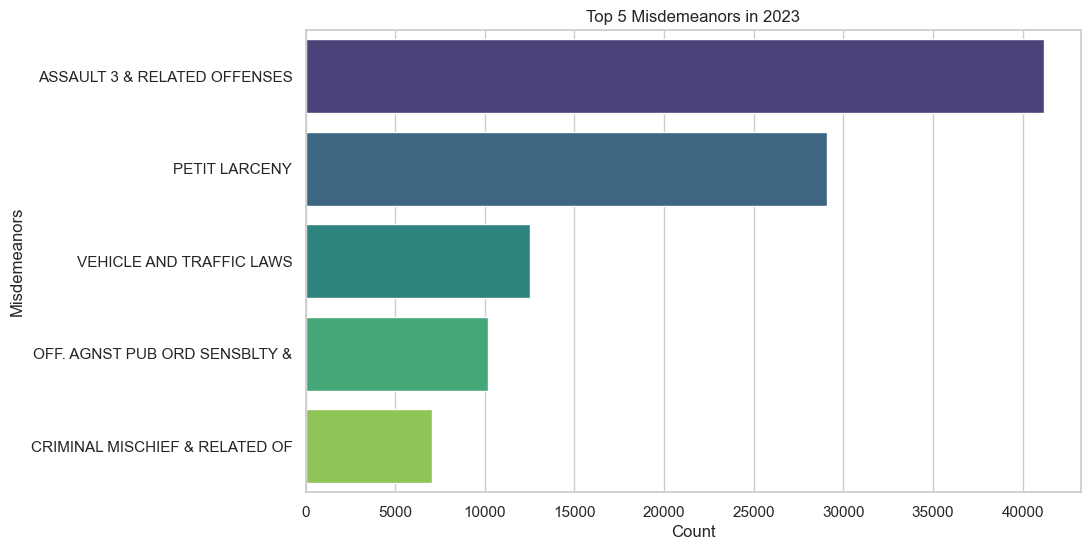

In [9]:
top_5_misdemeanor
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_misdemeanor.values, y=top_5_misdemeanor.index, palette="viridis")
plt.xlabel("Count")
plt.ylabel("Misdemeanors")
plt.title("Top 5 Misdemeanors in 2023")
plt.show()

Crime Breakdown by Month Line Graph 

In [10]:
df = pd.read_csv("crime_by_month.csv", encoding='utf-8', low_memory=False)
df = df.drop(df.index[-1])

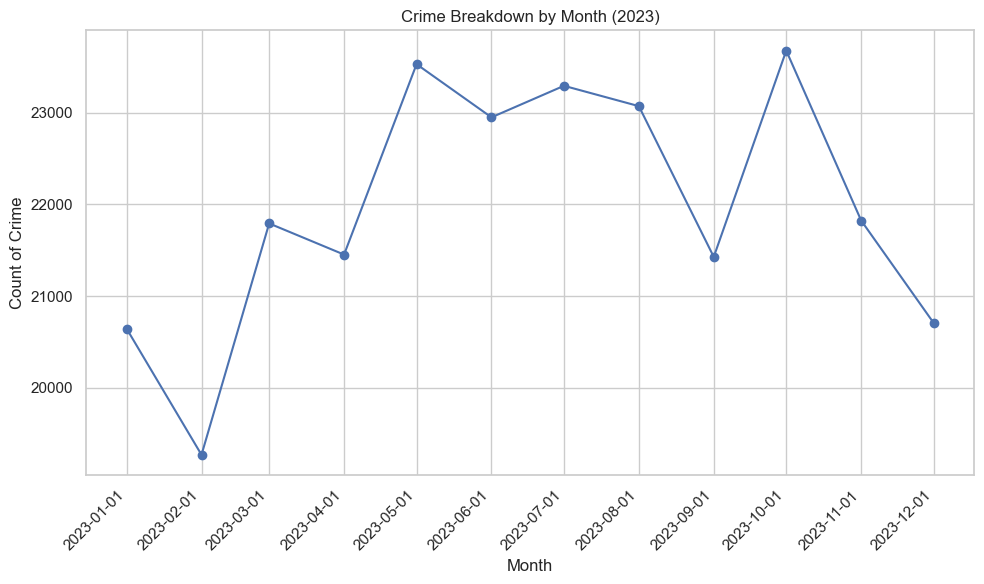

In [11]:
# Convert 'month' column to datetime
df['month'] = pd.to_datetime(df['month'])

# Plotting a line graph with formatted x-axis
plt.figure(figsize=(10, 6))
plt.plot(df['month'], df['count_of_records'], marker='o', linestyle='-', color='b')
plt.title('Crime Breakdown by Month (2023)')
plt.xlabel('Month')
plt.ylabel('Count of Crime')


# Format x-axis as dates
plt.xticks(df['month'], [date.strftime('%Y-%m-%d') for date in df['month']], rotation=45, ha='right')

plt.grid(True)
plt.tight_layout()
plt.show()